# RNN Based molucule generation

Laurent Cetinsoy

In this hands-on we want to generate molecule formulas for denovo-drug discovery.

For that we need to use Generative models. Generative models are models which goes beyond classification or simple regression : they are able to generate data that look like previously seens dataset.

There exists a lot of models :

- Bayesian models like graphical models
- Recurrent models (for sequence generation like texte)
- Variational auto encoders
- Generative adversarial models
- Flow and diffusion models


In the hands-on we will start by  trainning a character based RNN to generate smile molecules


We want to feed smile representations of molecules to an RNN.
The basic idea is we will train it to predict the next smile token of a molecule given the previous one.

For instance for the following molecule "CC(=O)NC1=CC=C(O)C=C1" will may give to the model

X = "CC(=O)N"
y = C

and ask the RNN to learn to predict y given X

Like a standard language model !


## RNN Language model


A language model is a model which predict the next token of a sequence given the previous ones :

$ P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p})  $


This model can be learned with a Recurrent neural network

$ y = P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p}) = RNN_{\theta} (X_{t-1}, X_{t-2}, ..., X_{t-p})  $


In order to train such model you need a corpus of data.



There are two main ways to do that : Word level model or character level model

For character level models, an interesting resource is : http://karpathy.github.io/2015/05/21/rnn-effectiveness/



Explain briefly what is the difference between word based language model and character based language model

## Loading the data

Dowload the following dataset : https://github.com/joeymach/Leveraging-VAE-to-generate-molecules

Import pandas and load the first 1000 lines

In [47]:
import pandas as pd

path_to_dataset = "250k_smiles.csv"

df = pd.read_csv(path_to_dataset, nrows=1000)

Display the first rows of the dataframe

In [48]:
df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


## Processing the data

We need to do the following things :

- convert smile tokens to numbers
- build  smile token sequences and corresponding labels pairs

Compute the biggest smile molecule size

In [49]:
def compute_largest_smiles_size(dataframe):
    max_len = df['smiles'].str.len().max()
    return max_len


Code a function **unic_characters(string)** which return the unic characters in a string


In [50]:
def unique_characters(string):
    return ''.join(set(string))

Concatenate all smile string of the pandas dataframe and use **unic_characters** to get the unic_characters

In [51]:
def get_unique_chars_in_dataset(dataframe):
    all_smiles = ''.join(dataframe['smiles'].values)
    unique_chars = unique_characters(all_smiles)
    return unique_chars

Code a function **map_char_to_int(unic_chars)** which returns a dictionnary where each char is assigned an int value.
Add a character to specify the end of the molecule (like "\n")


In [52]:
def map_char_to_int(unic_chars):
    char_to_int = {char: i for i, char in enumerate(unic_chars)}
    char_to_int['\n'] = len(unic_chars)  # Add the ending token
    return char_to_int

Code a function map_int_to_char(unic_chars) which returns the reverse mapping.

If you want you can merge both functions in a class

In [53]:
def map_int_to_char(unic_chars):
    int_to_char = {i: char for i, char in enumerate(unic_chars)}
    int_to_char[len(unic_chars)] = '\n'  # Map the ending token to '\n'
    return int_to_char

For each smile molecule add the ending token to it

In [54]:
def add_ending_token(smiles, ending_token):
    return smiles + ending_token


# Step 1: Compute the biggest SMILES molecule size
largest_smiles_size = compute_largest_smiles_size(df)

# Step 3: Get unique characters in the dataset
unique_chars = get_unique_chars_in_dataset(df)

# Step 4: Map characters to integers
char_to_int = map_char_to_int(unique_chars)

# Step 5: Map integers back to characters
int_to_char = map_int_to_char(unique_chars)

# Step 6: Add the ending token to each SMILES molecule
ending_token = '\n'
df['smiles'] = df['smiles'].apply(lambda x: add_ending_token(x, ending_token))


## Building the dataset

Now we will create the dataset so that it has the good share for our Keras LSTM model

Remember Keras recurrent models expect a 3D array with shapes (n_examples, seq_len, n_features)



What will be n_features in our case ?

Le nombre de caractéristiques (n_features) est égal à la somme du nombre de caractères uniques dans l'ensemble de données SMILES et de 1 pour le caractère de fin de molécule ("\n").

Code a function **build_X_and_y(string, i_char, seq_lenght)** which takes a string, a **seq_length** number and a position.


It should create X by by getting all character between i and i + seq_length
and create y by getting the character following the X sequence
it returns X and y

Test your function on the following string "" with seq_length = 4 and i = [1, 2, 3]

In [55]:
def build_X_and_y(string, i_char, seq_length):
    X, y = [], []
    for i in i_char:
        if i + seq_length < len(string):
            X.append(string[i:i + seq_length])
            y.append(string[i + seq_length])
    return X, y


# Test the function
test_string = "your_test_string"
seq_length = 4
i_positions = [1, 2, 3]

X, y = build_X_and_y(test_string, i_positions, seq_length)
for i in range(len(X)):
    print(f"X: '{X[i]}' => y: '{y[i]}'")

X: 'our_' => y: 't'
X: 'ur_t' => y: 'e'
X: 'r_te' => y: 's'


By using build_X_and_y and map_char_to_int build a list nameed X_train and a list named y_train

In [56]:
# Initialize empty lists for X_train and y_train
X_train = []
y_train = []

# Define the sequence length
seq_length = largest_smiles_size // 2

# Iterate through each SMILES molecule in your dataset
for smiles in df['smiles']:
    X, y = build_X_and_y(smiles, range(len(smiles) - seq_length), seq_length)

    # Convert X and y from characters to integers
    X = [[char_to_int[char] for char in seq] for seq in X]
    y = [char_to_int[char] for char in y]

    X_train.extend(X)
    y_train.extend(y)

print(f"X_train: {X_train}")
print(f"y_train: {y_train}")

X_train: [[26, 3, 21, 28, 31, 28, 28, 28, 24, 15, 28, 16, 28, 28, 28, 24, 13, 19, 21, 17, 17, 11, 18, 24, 21, 24, 23, 13, 7, 26, 2, 21, 21, 21, 21, 2, 7, 28, 2, 28, 28, 28, 28, 28, 2, 7, 28, 28, 16, 7, 28, 28, 31], [3, 21, 28, 31, 28, 28, 28, 24, 15, 28, 16, 28, 28, 28, 24, 13, 19, 21, 17, 17, 11, 18, 24, 21, 24, 23, 13, 7, 26, 2, 21, 21, 21, 21, 2, 7, 28, 2, 28, 28, 28, 28, 28, 2, 7, 28, 28, 16, 7, 28, 28, 31, 33], [21, 21, 13, 21, 24, 23, 13, 7, 19, 21, 17, 17, 11, 18, 31, 21, 21, 21, 26, 24, 21, 24, 23, 13, 7, 28, 16, 9, 28, 24, 15, 28, 2, 28, 28, 28, 24, 21, 7, 28, 28, 2, 7, 9, 2, 28, 16, 21, 21, 21, 21, 21, 2], [21, 13, 21, 24, 23, 13, 7, 19, 21, 17, 17, 11, 18, 31, 21, 21, 21, 26, 24, 21, 24, 23, 13, 7, 28, 16, 9, 28, 24, 15, 28, 2, 28, 28, 28, 24, 21, 7, 28, 28, 2, 7, 9, 2, 28, 16, 21, 21, 21, 21, 21, 2, 7], [13, 21, 24, 23, 13, 7, 19, 21, 17, 17, 11, 18, 31, 21, 21, 21, 26, 24, 21, 24, 23, 13, 7, 28, 16, 9, 28, 24, 15, 28, 2, 28, 28, 28, 24, 21, 7, 28, 28, 2, 7, 9, 2, 28, 16, 2

Create numpy arrays from the lists

In [57]:
import numpy as np

# Convert lists to NumPy arrays
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

# Check the shapes of the arrays
print("X_train_np shape:", X_train_np.shape)
print("y_train_np shape:", y_train_np.shape)

X_train_np shape: (1246, 53)
y_train_np shape: (1246,)


Reshape the X numpy array (n_examples, seq_lenght, 1)

In [58]:
# Reshape X_train_np
X_train_reshaped = X_train_np.reshape(
    X_train_np.shape[0], X_train_np.shape[1], 1)

# Check the shape of the reshaped array
print("X_train_reshaped shape:", X_train_reshaped.shape)

X_train_reshaped shape: (1246, 53, 1)


Normalize X by dividing each values by the total number of unic characters

In [59]:
# Step 1: Calculate the total number of unique characters
total_unique_chars = len(unique_chars)

# Step 2: Normalize X by dividing each value by the total number of unique characters
X_train_normalized = X_train_reshaped / total_unique_chars

# Check the shape of the normalized array
print("X_train_normalized shape:", X_train_normalized.shape)

X_train_normalized shape: (1246, 53, 1)


Import Keras and build (at least) a two layered LSTM network with 128 neurone in each.

You can also add Dropoutlayers

Do you think you should use the return_sequences = True ? If yes, when ?


Add a Dense layer on top with with the appropriate activation function and number of neurones


In [105]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

# Create a Sequential model
model = Sequential()

model.add(LSTM(128, return_sequences=True,
          input_shape=(X_train_reshaped.shape[1:]),))

model.add(LSTM(128, return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='linear')) 


Compile the model with the appropriate loss function and the adam optimizer

In [106]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# You might also want to specify metrics for evaluation, such as accuracy
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

Train the model on 20 epochs and 10 examples (yeah you read correctly) and check that the model overfits !

In [107]:
# Compile the model with an appropriate loss function (e.g., mean squared error), optimizer, and metrics
import matplotlib.pyplot as plt
import tensorflow as tf
model.compile(
    loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Print the model summary to see the architecture
model.summary()

# Convert X_normalized to a list of sequences of integers

# Train the model with 10 examples for 20 epochs
history = model.fit(tf.convert_to_tensor(X_train_reshaped[:10]), tf.convert_to_tensor(
    y_train_np[:10]), epochs=20, validation_split=0.2)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 53, 128)           66560     
                                                                 
 lstm_27 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 206,465
Trainable params: 206,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


1/1 [==============================] - 5s 5s/step - loss: 772.0425 - mean_absolute_error: 26.3369 - val_loss: 398.5350 - val_mean_absolute_error: 19.9633
Epoch 2/20
1/1 [==============================] - 0s 115ms/step - loss: 727.8760 - mean_absolute_error: 25.4973 - val_loss: 366.7823 - val_mean_absolute_error: 19.1516
Epoch 3/20
1/1 [==============================] - 0s 99ms/step - loss: 693.7922 - mean_absolute_error: 24.7966 - val_loss: 336.8076 - val_mean_absolute_error: 18.3523
Epoch 4/20
1/1 [==============================] - 0s 100ms/step - loss: 650.2264 - mean_absolute_error: 23.9058 - val_loss: 306.5113 - val_mean_absolute_error: 17.5075
Epoch 5/20
1/1 [==============================] - 0s 105ms/step - loss: 617.7352 - mean_absolute_error: 23.2199 - val_loss: 277.4781 - val_mean_absolute_error: 16.6577
Epoch 6/20
1/1 [==============================] - 0s 87ms/step - loss: 575.9429 - mean_absolute_error: 22.3524 - val_loss: 250.5860 - val_mean_absolute_error: 15.8299
Epoch 7/

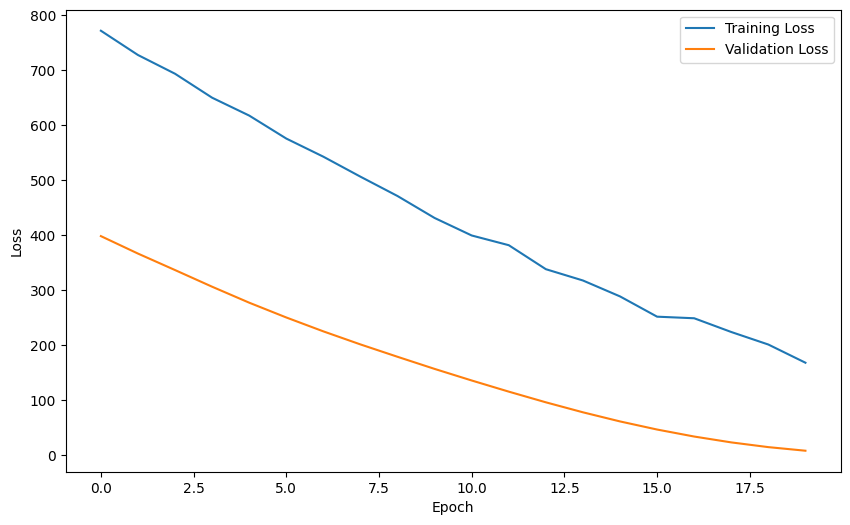

In [108]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

If it does not overfit try to fix data prep and model architecture so it does

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 53, 128)           66560     
                                                                 
 lstm_27 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 206,465
Trainable params: 206,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================

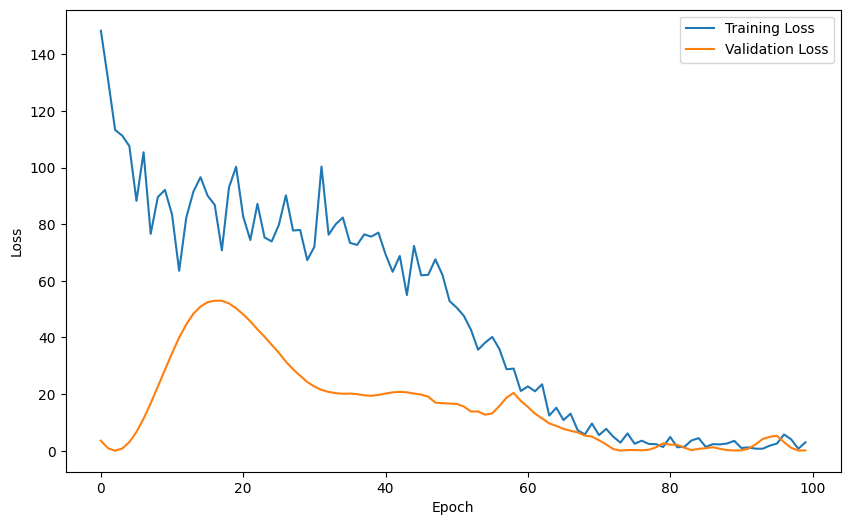

In [109]:
import matplotlib.pyplot as plt
import tensorflow as tf
model.compile(
    loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Print the model summary to see the architecture
model.summary()

# Convert X_normalized to a list of sequences of integers

# Train the model with 10 examples for 20 epochs
history = model.fit(tf.convert_to_tensor(X_train_reshaped[:10]), tf.convert_to_tensor(
    y_train_np[:10]), epochs=100, validation_split=0.2)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Create a function **make_prediction(seed_start)** which takes a starting string sequence and uses it to generate a molecule


In [118]:
def sample(preds, temperature=1.0):
    """
    Sample an index from a probability array.

    Parameters:
        preds (np.ndarray): The probability array.
        temperature (float): Controls the randomness of character selection (1.0 for randomness).

    Returns:
        int: The index of the selected character.
    """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_molecule(seed_start, model, max_length, temperature=1.0):
    """
    Generate a molecule sequence starting from seed_start using the provided model.

    Parameters:
        seed_start (int): the index of the molecule from the dataset.
        model (keras.Model): The trained model for molecule generation.
        max_length (int): Maximum length of the generated molecule sequence.
        temperature (float): Controls the randomness of character selection (1.0 for randomness).

    Returns:
        str: The generated molecule sequence.
    """
    # Initialize a list to contain the generated molecule sequence
    generated_sequence = [seed_start]

    # Iterate until the maximum length of the sequence is reached
    for i in range(max_length):
        # Create a batch of a single sequence (the current sequence)
        X = np.array([generated_sequence[-max_length:]])
        # Normalize the batch
        X_normalized = X / total_unique_chars
        # Get predictions for the next character
        y_pred = model.predict(X_normalized)[0]
        # Sample the output character using the provided temperature
        next_index = sample(y_pred, temperature)
        # Append the generated character index to the sequence
        generated_sequence.append(next_index)

    # Convert the sequence of indices to characters
    generated_sequence = [int_to_char[idx]
                          for idx in generated_sequence[1:]]

    # Join the characters into a single string
    generated_string = ''.join(generated_sequence)

    return generated_string

# example of how to use the function
seed_start = 0
generated_molecule = generate_molecule(
    seed_start, model, largest_smiles_size, temperature=1.0)
print(generated_molecule)

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 28ms/step
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


generate a molecule of your overfitted model

Make a model checkpoint so that the model is saved after each epoch
if you train on a plateform and it stops you do not lose your training

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.8651 - mean_absolute_error: 1.0185
Epoch 1: loss improved from inf to 1.86507, saving model to model.h5
1/1 [==============================] - 0s 209ms/step - loss: 1.8651 - mean_absolute_error: 1.0185 - val_loss: 0.4197 - val_mean_absolute_error: 0.6436
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 2.2796 - mean_absolute_error: 1.3131
Epoch 2: loss did not improve from 1.86507
1/1 [==============================] - 0s 100ms/step - loss: 2.2796 - mean_absolute_error: 1.3131 - val_loss: 0.3411 - val_mean_absolute_error: 0.5797
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 2.2214 - mean_absolute_error: 1.2707
Epoch 3: loss did not improve from 1.86507
1/1 [==============================] - 0s 108ms/step - loss: 2.2214 - mean_absolute_error: 1.2707 - val_loss: 0.0763 - val_mean_absolute_error: 0.2692
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 1.3511 - mean

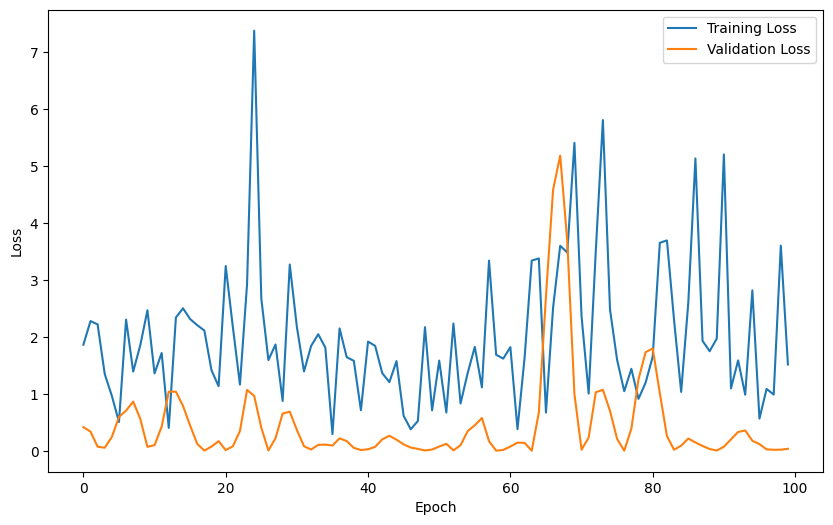

In [120]:
"""Make a model checkpoint so that the model is saved after each epoch
if you train on a plateform and it stops you do not lose your training"""
from keras.callbacks import ModelCheckpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Train the model with 10 examples for 20 epochs
history = model.fit(tf.convert_to_tensor(X_train_reshaped[:10]), tf.convert_to_tensor(
    y_train_np[:10]), epochs=100, validation_split=0.2, callbacks=callbacks_list)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Now go to your favorite plateform (colab or something else) and train the dataset on the whole data for 10 epochs and batch size 256

it should take a long time so either follow the class or go take a nap

Generate between 100 and 1000 molecules.

create a list where molecules have between 10 and 50 atoms

With rdkit compute the Quantified Estimated Drug likelyness (QED) of each molecule in this subset

Bonus 1 : Using rdkit, compute the quantitative estimation of drug-likeness (QED) of your generated molecules.

Bonus 2 : try to adapt a transformer model training from hugging face to see if it is better